# **TR_2021/16 - Technical report: Day and night variations of temperature and humidity**


|Technical Report ID  |2021/16|
|--|--|
| Title |Day and night variations of temperature and humidity|
| Authors | Júlia De Lázari, Paula Dornhofer|
| Creation Date| 2021-09|

Analyze the different between mean values of temperature and humidity during night and day and its impact on cardiovasculares outcomes.

## Databases descriptions

**inputs:** 

- obitos_circulatorio.csv: Dataframe of deaths due to cardiovascular diseases from 2001 to 2019 (only data up to 2018 was used, to match the climate data).

- hospitalizações_circulatorio.csv: Dataframe of hospitalizations due to cardiovascular diseases from 2014 to 2018.

- Cepagri_111_1997_2018.csv: Dataframe with weather data from CEPAGRI, measured every 10 minutes from 1997 to 2018.

##**Import libraries and load data**

In [2]:
! git clone https://github.com/climate-and-health-datasci-Unicamp/py-climate-health-toolbox

Cloning into 'py-climate-health-toolbox'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 142 (delta 70), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (142/142), 7.88 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [3]:
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import pylab 
import seaborn as sns
import math
import time
import datetime
import statistics as stat
from datetime import timedelta
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import locator_params
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

#climatex
import sys
sys.path.append('/content/py-climate-health-toolbox/climahe')
import climatex as tex

#files
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#-------------------------------------------------------------------#
#                          Load dataframe                           #
#-------------------------------------------------------------------#

df_cepagri = pd.read_csv('Cepagri_111_1997_2018.csv')
df_cepagri['DATE'] = pd.to_datetime(df_cepagri['YEAR'] * 1000 + df_cepagri['DAY365'], format='%Y%j')

#convert to datetime
df_cepagri['HRMINUTE'] = df_cepagri['HRMINUTE'].astype(str)
df_cepagri['HRMINUTE'] = df_cepagri['HRMINUTE'].map(lambda s: s[:-2])
df_cepagri['HRMINUTE'] = df_cepagri['HRMINUTE'].map(lambda s: "0000" if s=='2400' else s)
df_cepagri['HRMINUTE'] = df_cepagri['HRMINUTE'].map(lambda s: "00" + s if len(s)==2 else s)
df_cepagri['HRMINUTE'] = df_cepagri['HRMINUTE'].map(lambda s: "0" + s if len(s)==3 else s)
df_cepagri['HRMINUTE'] = pd.to_datetime(df_cepagri['HRMINUTE'],format = '%H%M',errors='coerce').dt.strftime('%H:%M')

df_cepagri['DATETIME'] = df_cepagri['DATE'].astype(str) + ' ' + df_cepagri['HRMINUTE'].astype(str)
df_cepagri['DATETIME'] = pd.to_datetime(df_cepagri['DATETIME'],errors='coerce')

#keep only relevant columns
df_cepagri = df_cepagri[['DATETIME','DATE','HRMINUTE','N_RHMEAN_10','N_AIRTMP_MEAN']]

In [5]:
#drop rows with null hour and minute
df_cepagri = df_cepagri[~df_cepagri['HRMINUTE'].isnull()]

In [6]:
#adjust for 00:00
df_cepagri['DATETIME'] = np.where(df_cepagri['HRMINUTE']=='00:00',df_cepagri['DATETIME']+timedelta(days=1),df_cepagri['DATETIME'])
df_cepagri['DATE'] = np.where(df_cepagri['HRMINUTE']=='00:00',df_cepagri['DATE']+timedelta(days=1),df_cepagri['DATE'])

df_cepagri = df_cepagri.sort_values('DATETIME')

In [7]:
# create a column for season

summer = [12,1,2]
autumn = [3,4,5]
winter = [6,7,8]
spring = [9,10,11]

df_cepagri['MONTH'] = df_cepagri['DATE'].dt.strftime('%m').astype(int)
df_cepagri.loc[df_cepagri['MONTH'].isin(summer), 'SEASON'] = 'Summer'
df_cepagri.loc[df_cepagri['MONTH'].isin(autumn), 'SEASON'] = 'Autumn'
df_cepagri.loc[df_cepagri['MONTH'].isin(winter), 'SEASON'] = 'Winter'
df_cepagri.loc[df_cepagri['MONTH'].isin(spring), 'SEASON'] = 'Spring'

##**Divide into time periods - 6hrs**

In [8]:
#column to indicate part of day
# 1 - 0h to 6h
# 2 - 7h to 12h
# 3 - 13h to 18h
# 4 - 19h to 24h

conditions = [
    (df_cepagri['HRMINUTE'] >'00:00') & (df_cepagri['HRMINUTE'] <='06:00'),
    (df_cepagri['HRMINUTE']> '06:00') & (df_cepagri['HRMINUTE'] <='12:00'),
    (df_cepagri['HRMINUTE']> '12:00') & (df_cepagri['HRMINUTE'] <='18:00'),
    (df_cepagri['HRMINUTE']>'18:00') | (df_cepagri['HRMINUTE']=='00:00')]

values = ['1','2','3','4']

df_cepagri['PERIOD'] = np.select(conditions, values)

###**Descriptives**

In [11]:
df_aux = df_cepagri[df_cepagri['DATE']>='2001-01-01']

In [12]:
df_dawn = df_aux[df_aux['PERIOD']=='1']
df_morning = df_aux[df_aux['PERIOD']=='2']
df_afternoon = df_aux[df_aux['PERIOD']=='3']
df_night = df_aux[df_aux['PERIOD']=='4']

In [13]:
df_dawn['N_AIRTMP_MEAN'].describe()

count    232628.000000
mean         17.957107
std           3.119878
min           4.752000
25%          15.920000
50%          18.380000
75%          20.310000
max          44.900000
Name: N_AIRTMP_MEAN, dtype: float64

In [14]:
df_morning['N_AIRTMP_MEAN'].describe()

count    233073.000000
mean         21.918570
std           4.736217
min           4.000000
25%          18.780000
50%          22.100000
75%          25.430000
max          45.000000
Name: N_AIRTMP_MEAN, dtype: float64

In [15]:
df_afternoon['N_AIRTMP_MEAN'].describe()

count    233266.000000
mean         26.513226
std           4.172756
min           4.000000
25%          23.790000
50%          26.870000
75%          29.550000
max          45.000000
Name: N_AIRTMP_MEAN, dtype: float64

In [16]:
df_night['N_AIRTMP_MEAN'].describe()

count    232897.000000
mean         20.725323
std           3.474513
min           6.923000
25%          18.540000
50%          20.780000
75%          22.890000
max          45.000000
Name: N_AIRTMP_MEAN, dtype: float64

In [17]:
df_dawn['N_RHMEAN_10'].describe()

count    232682.000000
mean         85.764589
std          10.765758
min          23.050000
25%          80.300000
50%          87.300000
75%          93.600000
max         100.000000
Name: N_RHMEAN_10, dtype: float64

In [18]:
df_morning['N_RHMEAN_10'].describe()

count    233405.000000
mean         72.863052
std          16.582508
min           8.000000
25%          61.260000
50%          73.800000
75%          85.800000
max         100.000000
Name: N_RHMEAN_10, dtype: float64

In [19]:
df_afternoon['N_RHMEAN_10'].describe()

count    233601.000000
mean         55.835414
std          18.654442
min           7.580000
25%          42.640000
50%          53.770000
75%          67.130000
max         100.000000
Name: N_RHMEAN_10, dtype: float64

In [20]:
df_night['N_RHMEAN_10'].describe()

count    232931.00000
mean         75.28428
std          15.80812
min           8.23000
25%          65.91000
50%          77.50000
75%          86.60000
max         100.00000
Name: N_RHMEAN_10, dtype: float64

###**Plots**

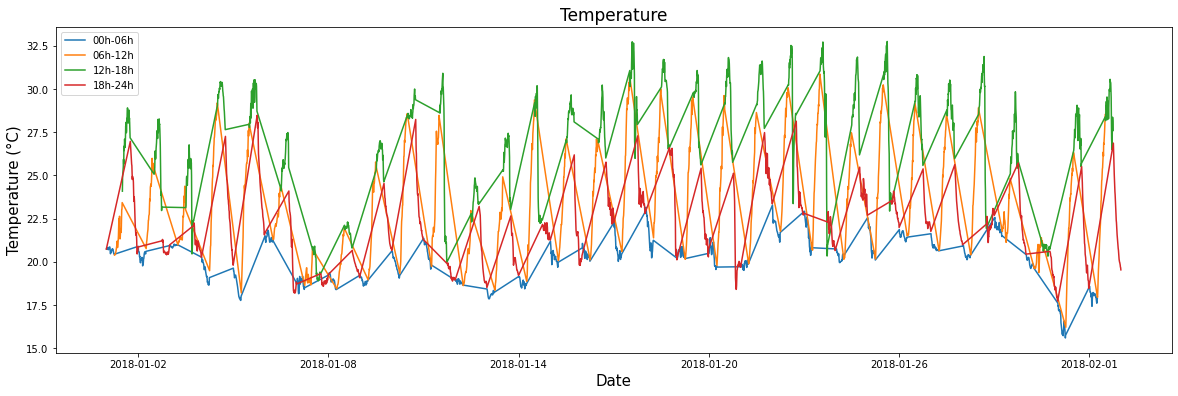

In [21]:
#Create auxiliar dataframes
df_aux = df_cepagri[(df_cepagri['DATE']>='2018-01-01') & (df_cepagri['DATE']<='2018-02-01')]
df_aux1 = df_aux[df_aux['PERIOD']=='1']
df_aux2 = df_aux[df_aux['PERIOD']=='2']
df_aux3 = df_aux[df_aux['PERIOD']=='3']
df_aux4 = df_aux[df_aux['PERIOD']=='4']

# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 6))

# Plot
ax.plot(df_aux1['DATETIME'], df_aux1['N_AIRTMP_MEAN'],color = 'C0',label='00h-06h')
ax.plot(df_aux2['DATETIME'], df_aux2['N_AIRTMP_MEAN'],color = 'C1',label='06h-12h')
ax.plot(df_aux3['DATETIME'], df_aux3['N_AIRTMP_MEAN'],color = 'C2',label='12h-18h')
ax.plot(df_aux4['DATETIME'], df_aux4['N_AIRTMP_MEAN'],color = 'C3',label='18h-24h')

ax.set_title("Temperature", fontsize = 17)
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Temperature (°C)",fontsize = 15)

ax.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.legend()
plt.show()

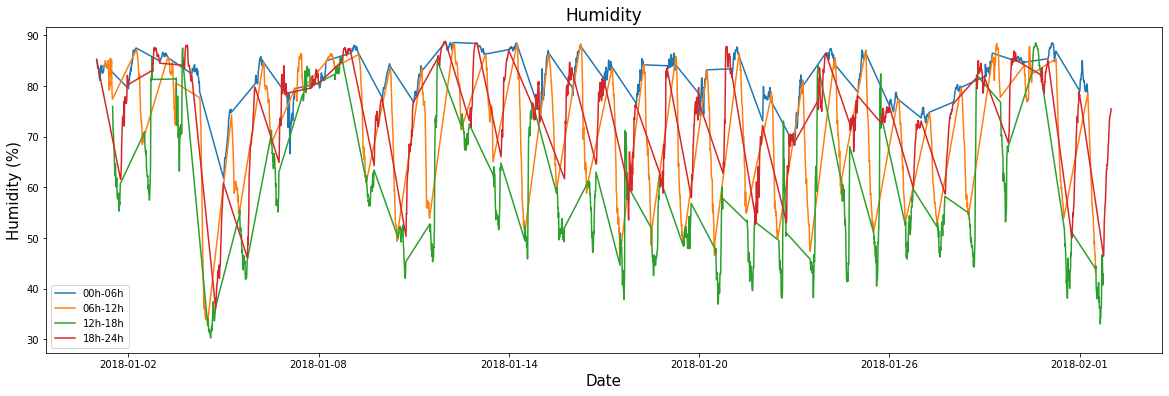

In [22]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 6))

# Plot
ax.plot(df_aux1['DATETIME'], df_aux1['N_RHMEAN_10'],color = 'C0',label='00h-06h')
ax.plot(df_aux2['DATETIME'], df_aux2['N_RHMEAN_10'],color = 'C1',label='06h-12h')
ax.plot(df_aux3['DATETIME'], df_aux3['N_RHMEAN_10'],color = 'C2',label='12h-18h')
ax.plot(df_aux4['DATETIME'], df_aux4['N_RHMEAN_10'],color = 'C3',label='18h-24h')

ax.set_title("Humidity", fontsize = 17)
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Humidity (%)",fontsize = 15)

ax.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.legend()
plt.show()

##**Mean values**

In [23]:
# dataframe with mean values
df = pd.DataFrame()

df['DATE'] = df_cepagri['DATE'] 
df['SEASON'] = df_cepagri['SEASON'] 
df['PERIOD'] = df_cepagri['PERIOD'] 
df['RH'] = round(df_cepagri.groupby(['DATE','PERIOD'])['N_RHMEAN_10'].transform('mean'),2)
df['TMP'] = round(df_cepagri.groupby(['DATE','PERIOD'])['N_AIRTMP_MEAN'].transform('mean'),2)

df = df.drop_duplicates(['DATE','PERIOD'])

df = df[(df['PERIOD']=='1') | (df['PERIOD']=='3')]

###**Plots**

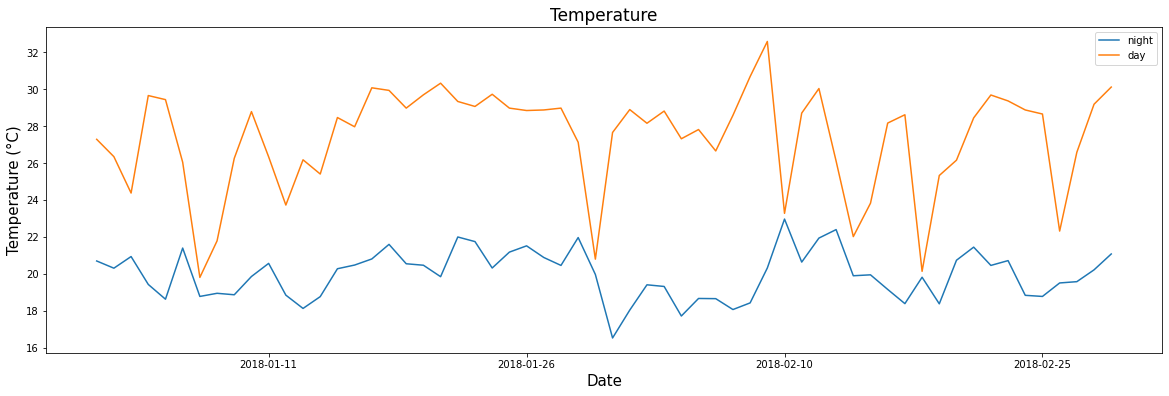

In [24]:
df_aux = df[(df['DATE']>='2018-01-01') & (df['DATE']<='2018-03-01')]
df_aux1 = df_aux[df_aux['PERIOD']=='1']
df_aux2 = df_aux[df_aux['PERIOD']=='3']

# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 6))

# Plot
ax.plot(df_aux1['DATE'], df_aux1['TMP'],color = 'C0',label='night')
ax.plot(df_aux2['DATE'], df_aux2['TMP'],color = 'C1',label='day')

ax.set_title("Temperature", fontsize = 17)
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Temperature (°C)",fontsize = 15)

ax.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.legend()
plt.show()

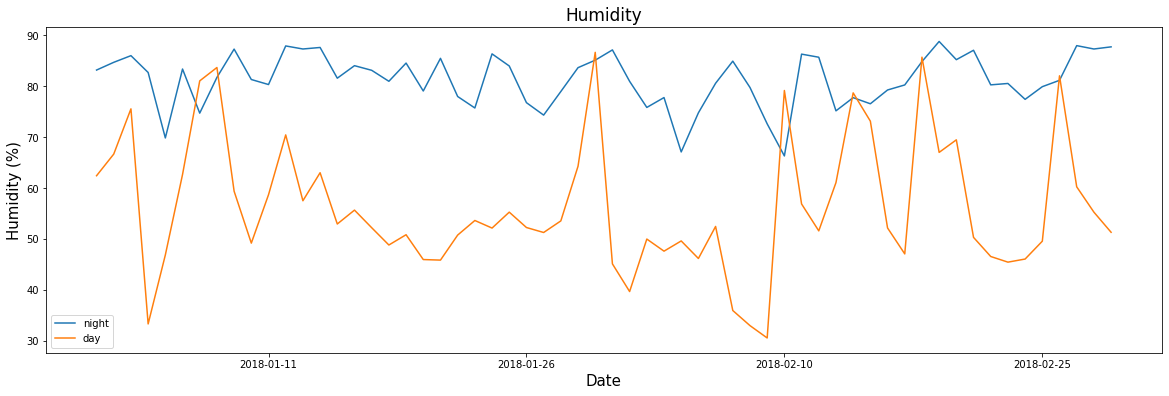

In [25]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 6))

# Plot
ax.plot(df_aux1['DATE'], df_aux1['RH'],color = 'C0',label='night')
ax.plot(df_aux2['DATE'], df_aux2['RH'],color = 'C1',label='day')

ax.set_title("Humidity", fontsize = 17)
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Humidity (%)",fontsize = 15)

ax.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.legend()
plt.show()

###**Difference between days**

In [26]:
#use shift to compute de diferences
df['DIF_RH'] = df['RH'] - df['RH'].shift(1)
df['DIF_TMP'] = df['TMP'] - df['TMP'].shift(1)

#only wanted period
df2 = df[df['PERIOD']=='1']

#keep only relevant coluns
df2 = df2[['DATE','SEASON','DIF_RH','DIF_TMP']]

df2 = df2[1:-1:]

df2['DATE'] = pd.to_datetime(df2['DATE'])

##**Extreme temperature event**

In [27]:
#Adapated from climatex library
#-------------------------------------------------------------------------------
## Checks for days a small difference between day and night temperature according to the Climatic Normal
##
## Extreme event is defined as days with temperature difference below the 10th percentile
## (percentiles computed with a 15 day windom average and regarding the climatic normal)
##
## Climatic Normal dataframe needs to have at least 'DATE' and 'pct_column'
## Database dataframe needs to have at least 'DATE' and 'db_column' IF either or
## one of those dataframes don't have the 'DAY365' column (day of the year
## column), cn_columnDay365 and/or db_columnDay365 parameters must be False,
## otherwise True
## 
## ATTENTION The column DATE of both dataframes needs to be converted to
## pandas.datetime and needs to be called DATE
##
## If there are missing dates on the database, db_complete parameter must be
## False, otherwise True
##
## In case the df_pct was previously obtained, set df_pct = Dataframe obtained
## and set climatic_normal and pct_columns to None or any value/dataframe.
##
## :param      database:          The database
## :type       database:          pandas.DataFrame
## :param      db_columnMAX:      The column of the database with maximum
##                                values of temperature to be compared with CMX_pct
## :type       db_columnMAX:      String
## :param      db_columnMIN:      The column of the database with minimum
##                                values of temperature to be compared with CMN_pct
## :type       db_columnMIN:      String
## :param      climatic_normal:   The climatic normal
## :type       climatic_normal:   pandas.DataFrame
## :param      pct_columnMAX:     Name of the column from the climatic normal
##                                used to calculate the percentile for maximum
##                                values of temperature
## :type       pct_columnMAX:     String
## :param      pct_columnMIN:     Name of the column from the climatic normal
##                                used to calculate the percentile for minimum
##                                tvalues of temperature
## :type       pct_columnMIN:     String
## :param      db_columnDay365:   Indicates if the database has the Day365/day
##                                of the year column (db_columnDay365 = True) or
##                                not (db_columnDay365 = False)
## :type       db_columnDay365:   Boolean (True or False)
## :param      db_complete:       Indicates if the database has missing dates
##                                (db_complete = False) or not (db_complete =
##                                True)
## :type       db_complete:       Boolean (True or False)
## :param      cn_columnDay365:   Indicates if the climatic normal has the
##                                Day365/day of the year column (cn_columnDay365
##                                = True) or not (cn_columnDay365 = False)
## :type       cn_columnDay365:   Boolean (True or False)
## :param      df_pct:            The df pct - in case the dataframe with
##                                percentiles was already obtained and is going
##                                to reused, otherwise set df_pct = None
##                                (default)
## :type       df_pct:            pandas.DataFrame
## :param      percentile_value:  The percentile value (0 to 1.0) - default 0.9
## :type       percentile_value:  Float
## :param      window_size:       The size of the window used to calculate the
##                                percentile - default 15 days
## :type       window_size:       Integer
##
## :returns:   df_pdif -> database dataframe including columns 'dif_max','dif_min'
##             and 'above_pct_dif' 
##             df_pct -> dataframe with percentiles for each day of the
##             year (1 to 365)
## :rtype:     pandas.DataFrame
##
def check_day_night_temp(database,db_column,climatic_normal,pct_colum, db_columnDay365=False,db_complete=False,cn_columnDay365=False,df_pct = None,percentile_value=0.1,window_size=15):
    
    if not db_complete:#in case db is incomplete - with missing dates
        database= tex.complete_df(database) #add the missing dates without altering original db
    if not db_columnDay365: #in case there is no 'DAY365' column
        database = tex.date_toDay365(database) #add column 'DAY365' to the dataframe
    
    database = tex.drop_leapday(database) #removes leap day from the database

    if df_pct is None:
        
        if not cn_columnDay365: #in case there is no 'DAY365' column
            climatic_normal = tex.date_toDay365(climatic_normal) #add column 'DAY365' to the dataframe
                
        climatic_normal = tex.drop_leapday(climatic_normal) #removes leap day from climatic normal

        df_pct = pd.DataFrame() #creates a dataframe to store the percentiles
        df_pct['DAY365']=range(1,366) #creates 'DAY365' column with each row receiving values 1 to 365
        df_pct=df_pct.set_index(['DAY365']) # 'DAY365' is set as index
        
        #obtain values for the 10th percentile
        df_pct['CMX10pct'] = df_pct.index.map(lambda day365_index: tex.get_percentile(climatic_normal,day365_index,'DIF_TMP',percentile_value,window_size))
        df_pct['CMN10pct'] = df_pct.index.map(lambda day365_index: tex.get_percentile(climatic_normal,day365_index,'DIF_TMP',percentile_value,window_size))
     
    df_pdif = tex.get_belowPct_wave(database,df_pct,'DIF_TMP','DIF_TMP') #df_dif receives the database plus 'above_pct' column

    return df_pdif, df_pct

In [28]:
df_clima, pct_tmp = check_day_night_temp(df2,'DIF_TMP',df2,'DIF_TMP')

In [29]:
df_clima = df_clima.rename(columns={'below_pct':'below_pct_tmp'})

In [30]:
#data after 2001
df_aux = df_clima[df_clima['DATE']>='2001-01-01']

##**Extreme humidity event**

In [31]:
#Adapated from climatex library
#-------------------------------------------------------------------------------
## Checks for days a small difference between day and night humidity according to the Climatic Normal
##
## Extreme event is defined as days with humidity difference below the 10th percentile
## (percentiles computed with a 15 day windom average and regarding the climatic normal)
##
## Climatic Normal dataframe needs to have at least 'DATE' and 'pct_column'
## Database dataframe needs to have at least 'DATE' and 'db_column' IF either or
## one of those dataframes don't have the 'DAY365' column (day of the year
## column), cn_columnDay365 and/or db_columnDay365 parameters must be False,
## otherwise True
## 
## ATTENTION The column DATE of both dataframes needs to be converted to
## pandas.datetime and needs to be called DATE
##
## If there are missing dates on the database, db_complete parameter must be
## False, otherwise True
##
## In case the df_pct was previously obtained, set df_pct = Dataframe obtained
## and set climatic_normal and pct_columns to None or any value/dataframe.
##
## :param      database:          The database
## :type       database:          pandas.DataFrame
## :param      db_columnMAX:      The column of the database with maximum
##                                values of humidity to be compared with CMX_pct
## :type       db_columnMAX:      String
## :param      db_columnMIN:      The column of the database with minimum
##                                values of humidity to be compared with CMN_pct
## :type       db_columnMIN:      String
## :param      climatic_normal:   The climatic normal
## :type       climatic_normal:   pandas.DataFrame
## :param      pct_columnMAX:     Name of the column from the climatic normal
##                                used to calculate the percentile for maximum
##                                values of humidity
## :type       pct_columnMAX:     String
## :param      pct_columnMIN:     Name of the column from the climatic normal
##                                used to calculate the percentile for minimum
##                                tvalues of humidity
## :type       pct_columnMIN:     String
## :param      db_columnDay365:   Indicates if the database has the Day365/day
##                                of the year column (db_columnDay365 = True) or
##                                not (db_columnDay365 = False)
## :type       db_columnDay365:   Boolean (True or False)
## :param      db_complete:       Indicates if the database has missing dates
##                                (db_complete = False) or not (db_complete =
##                                True)
## :type       db_complete:       Boolean (True or False)
## :param      cn_columnDay365:   Indicates if the climatic normal has the
##                                Day365/day of the year column (cn_columnDay365
##                                = True) or not (cn_columnDay365 = False)
## :type       cn_columnDay365:   Boolean (True or False)
## :param      df_pct:            The df pct - in case the dataframe with
##                                percentiles was already obtained and is going
##                                to reused, otherwise set df_pct = None
##                                (default)
## :type       df_pct:            pandas.DataFrame
## :param      percentile_value:  The percentile value (0 to 1.0) - default 0.9
## :type       percentile_value:  Float
## :param      window_size:       The size of the window used to calculate the
##                                percentile - default 15 days
## :type       window_size:       Integer
##
## :returns:   df_pdif -> database dataframe including columns 'dif_max','dif_min'
##             and 'above_pct_dif' 
##             df_pct -> dataframe with percentiles for each day of the
##             year (1 to 365)
## :rtype:     pandas.DataFrame
##
def check_day_night_humidity(database,db_column,climatic_normal,pct_colum, db_columnDay365=False,db_complete=False,cn_columnDay365=False,df_pct = None,percentile_value=0.1,window_size=15):
    
    if not db_complete:#in case db is incomplete - with missing dates
        database= tex.complete_df(database) #add the missing dates without altering original db
    if not db_columnDay365: #in case there is no 'DAY365' column
        database = tex.date_toDay365(database) #add column 'DAY365' to the dataframe
    
    database = tex.drop_leapday(database) #removes leap day from the database

    if df_pct is None:
        
        if not cn_columnDay365: #in case there is no 'DAY365' column
            climatic_normal = tex.date_toDay365(climatic_normal) #add column 'DAY365' to the dataframe
                
        climatic_normal = tex.drop_leapday(climatic_normal) #removes leap day from climatic normal

        df_pct = pd.DataFrame() #creates a dataframe to store the percentiles
        df_pct['DAY365']=range(1,366) #creates 'DAY365' column with each row receiving values 1 to 365
        df_pct=df_pct.set_index(['DAY365']) # 'DAY365' is set as index
        
        #obtain values for the 90th percentile
        df_pct['CMX10pct'] = df_pct.index.map(lambda day365_index: tex.get_percentile(climatic_normal,day365_index,'DIF_RH',percentile_value,window_size))
        df_pct['CMN10pct'] = df_pct.index.map(lambda day365_index: tex.get_percentile(climatic_normal,day365_index,'DIF_RH',percentile_value,window_size))
     
    df_pdif = tex.get_belowPct_wave(database,df_pct,'DIF_RH','DIF_RH') #df_dif receives the database plus 'above_pct' column

    return df_pdif, df_pct

In [32]:
df_clima, pct_humidity = check_day_night_humidity(df_clima,'DIF_RH',df_clima,'DIF_RH')

In [33]:
df_clima = df_clima.rename(columns={'below_pct':'below_pct_humidity'})

In [34]:
df_aux = df_clima[df_clima['DATE']>='2001-01-01']

##**Load and merge health databases**

###**Hospitalizations**

In [35]:
#-------------------------------------------------------------------#
#                      Circulatory hospitalizations                 #
#-------------------------------------------------------------------#

df_hosp = pd.read_csv('hospitalizações_circulatório.csv')
df_hosp = df_hosp.drop(columns = {'Unnamed: 0','Hora','Número Paciente','Descrição CID'}) #drop unneeded columns
df_hosp = df_hosp.rename(columns = {'Data':'DATE','Idade': 'IDADE','Sexo': 'SEXO'}) #rename Data to DATE to merge dataframes
df_hosp = df_hosp[(df_hosp.DATE !='2012-02-29')&(df_hosp.DATE !='2016-02-29')] #remove leap year dates (02-29)
df_hosp = df_hosp.sort_values('DATE')
df_hosp['DATE'] = pd.to_datetime(df_hosp['DATE'])

In [36]:
#-------------------------------------------------------------------#
#              Merge health and climate dataframes                  #
#-------------------------------------------------------------------#
df_clima1 = df_clima[df_clima['DATE']>='2014-01-01']

df_1 = pd.merge(df_hosp,df_clima1, on='DATE', how='outer')
df_1 = df_1.sort_values('DATE')

###**Deaths**

In [37]:
#-------------------------------------------------------------------#
#                      Circulatory hospitalizations                 #
#-------------------------------------------------------------------#

df_obitos = pd.read_csv('obitos_circulatorio.csv')
df_obitos = df_obitos[df_obitos['CODMUNOCOR']==3509502] #keep only deaths that occured in Campinas
df_obitos = df_obitos.drop(columns = {'Unnamed: 0','HORAOBITO','CODMUNRES','CODMUNOCOR','COMPLRES',
                                      'CAUSABAS','LINHAA','LINHAB','LINHAC','LINHAD','LINHAII','Descrição CID'})
df_obitos = df_obitos.rename(columns = {'DTOBITO':'DATE'}) #rename DTOBITO to DATE to merge dataframes
df_obitos['DATE'] = pd.to_datetime(df_obitos['DATE']) #date to datetime format
df_obitos = df_obitos[df_obitos['DATE'].dt.strftime('%Y')>'2000'] #drop data from 2000 (inconsistent numbers) 
df_obitos = df_obitos[df_obitos['DATE'].dt.strftime('%Y')<'2019'] #consider only data until 2018 (climate data)

In [38]:
#-------------------------------------------------------------------#
#              Merge health and climate dataframes                  #
#-------------------------------------------------------------------#
df_clima2 = df_clima[df_clima['DATE']>='2001-01-01']

df_2 = pd.merge(df_obitos,df_clima2, on='DATE', how='outer')
df_2 = df_2.sort_values('DATE')

## **Functions**

Automatize some repeated operations along the notebook
- stratify functions: different stratifications of the dataframe
- rate_ratio: compute the rate ratio for the desired stratification
- mann_whitney: mann whitney u test for the desired stratification

###**Stratify functions**

In [39]:
# Stratify sex
def stratify_sex(database):
  women = database[database['SEXO']=='F']
  men = database[database['SEXO']=='M']

  dataframes = [database, women, men]
  df_names = ["All", "Women", "Men"]

  return dataframes, df_names

In [40]:
#Stratify age
def stratify_age(database):
  #less_20 = database[(database['IDADE'] < 20)]  
  between_20_40 = database[(database['IDADE'] >= 20) & (database['IDADE'] < 40)]
  between_40_65 = database[(database['IDADE'] >= 40) & (database['IDADE'] < 65)]   
  over_65 = database[(database['IDADE'] > 64)]   
  over_75 = database[(database['IDADE'] > 75)]

  dataframes  = [database, between_20_40, between_40_65, over_65, over_75] 
  df_names = ["All", "Between 20 and 40 years old","Between 40 and 65 years old","Above 65 years old","Above 75 years old"]

  return dataframes, df_names

In [41]:
# Stratify age sex
def stratify_age_sex2(database): 
    between_20_65_F = database[(database['IDADE'] >= 20) & (database['IDADE'] < 65)  & (database['SEXO']=="F")]
    between_20_65_M = database[(database['IDADE'] >= 20) & (database['IDADE'] < 65) & (database['SEXO']=="M")]   
    over_65_F = database[(database['IDADE'] > 64) & (database['SEXO']=="F")]   
    over_65_M = database[(database['IDADE'] > 64) & (database['SEXO']=="M")]     

    dataframes = [database, between_20_65_F, between_20_65_M,over_65_F,over_65_M]
    df_names = ["All", "Women between 20 and 65 years old","Men between 20 and 65 years old","Women above 65 years old","Men above 65 years old"]

    return dataframes, df_names

In [42]:
# Stratify age sex
def stratify_age_sex(database): 
    under_65_F = database[(database['IDADE'] < 65)  & (database['SEXO']=="F")]
    under_65_M = database[(database['IDADE'] < 65) & (database['SEXO']=="M")]   
    over_65_F = database[(database['IDADE'] > 64) & (database['SEXO']=="F")]   
    over_65_M = database[(database['IDADE'] > 64) & (database['SEXO']=="M")]     

    dataframes = [database, under_65_F, under_65_M,over_65_F,over_65_M]
    df_names = ["All", "Women under years old","Men under 65 years old","Women above 65 years old","Men above 65 years old"]

    return dataframes, df_names

###**Rate ratio function**

In [43]:
def rate_ratio(db, stratify,event):
  database = db.copy()

  #subsets depending on the stratification
  if (stratify == 'age and sex'): 
    dataframes, df_names = stratify_age_sex(database)
  elif (stratify == 'sex'): 
    dataframes, df_names = stratify_sex(database)
  elif (stratify == 'age'): 
    dataframes, df_names = stratify_age(database)
  
  #aux variable 
  list_rr = []
  list_up_ci = []
  list_lr_ci = []

  for df in dataframes:
    #column for number of hospitalizations
    df['N_hosp'] = np.where(df['CID'].isnull(),0,df.groupby(['DATE']).DATE.transform('count'))
    df = df.drop_duplicates('DATE',keep='first')
    df = df.sort_values('DATE')
      
    number_event = len(df[df[event] ==1]) # number of days with a extreme event
    number_control = len(df[df[event] ==0]) # number of days without a extreme event

    hosp_event = df.N_hosp[df[event] ==1].sum() # total number of hosp during a extreme event
    hosp_control = df.N_hosp[df[event] == 0].sum() # total number of hosp during control days

    # Rate ratio and confidence interval
    RR = round((hosp_event/number_event)/(hosp_control/number_control), 2) # compute rate ratio
    SE = math.sqrt(1/hosp_event + 1/hosp_control)

    upper_CI = round(np.exp(math.log(RR)+1.96*SE),2) #upper value
    lower_CI = round(np.exp(math.log(RR)-1.96*SE),2) #lower value

    # Append values in the list
    list_rr.append(RR)
    list_up_ci.append(upper_CI)
    list_lr_ci.append(lower_CI)

  #Create table
  table = pd.DataFrame()
  table['Group'] = df_names
  table['Rate ratio (RR)'] = list_rr
  table['Upper CI'] = list_up_ci
  table['Lower CI'] = list_lr_ci

  return table

###**Mann Whitney function**

In [44]:
def get_mann_whitney_lag(database,stratify,event,test='two-sided',plot=None):
  from scipy.stats import mannwhitneyu

  #aux lists
  u_stat = []
  p = [] 
  sig = []
  mean_event = []
  median_event = []
  mean_control = []
  median_control = []
  lag_list = []
  subsets_list = []

  #subsets depending on the stratification
  if (stratify == 'age and sex'): 
    dataframes, df_names = stratify_age_sex(database)
  elif (stratify == 'sex'): 
    dataframes, df_names = stratify_sex(database)
  elif (stratify == 'age'): 
    dataframes, df_names = stratify_age(database)
  elif (stratify == 'race'):
    dataframes, df_names = stratify_race(database)

  #aux variable 
  j = 0
  for df in dataframes: #mann whitney for each subset
    #column for number of deaths
    df['N_hosp'] = np.where(df['CID'].isnull(),0,df.groupby(['DATE']).DATE.transform('count'))
    df = df.drop_duplicates('DATE',keep='first')
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['YEAR'] = df['DATE'].dt.year
    df = tex.complete_df(df)
    df['N_hosp'].fillna(0,inplace=True)

    for lag in range(0,4):
      
      #subset for extreme event
      df[f'{event}_lag_{lag}'] = df[f'{event}'].shift(lag)
      df_event = df[df[f'{event}_lag_{lag}']==1]
      
      #subset for control
      df_control = df[df[f'{event}_lag_{lag}']==0]
    
      #get mean and median for event and control
      mean_event.append(round(stat.mean(df_event['N_hosp']),2))
      mean_control.append(round(stat.mean(df_control['N_hosp']),2))

      # mann whitney u test
      u_statistic, p_value = mannwhitneyu(df_event['N_hosp'], df_control['N_hosp'], alternative = test)
      p_sig = np.where(p_value<0.05,'*','-') #mark if p is significant
      u_stat.append(u_statistic)
      p.append(round(p_value,3))
      sig.append(p_sig)
      lag_list.append(lag)
      subsets_list.append(df_names[j])

      if p_value < 0.05:
        if (plot=='boxplot'):
          get_boxplot(df_control,df_event,df_names[j]+'lag'+str(lag), outcome)
        if (plot=='dist'):
          get_dist(database,df_control,df_event,df_names[j]+'lag'+str(lag), outcome)
      
    j += 1 #increment variable

  table = pd.DataFrame() #create a table
  table['Group'] = subsets_list
  table['Lag'] = lag_list
  table['U Statistic'] = u_stat
  table['P'] = p
  table['Significance'] = sig
  table['Mean event'] = mean_event
  table['Mean control'] = mean_control
  table = table[table['Significance']=='*']
  del table['Significance']

  return table

##**Analysis temperature**

###**Hospitalizations**

In [45]:
rate_ratio(df_1, 'sex','below_pct_tmp')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,1.04,1.11,0.98
1,Women,1.01,1.11,0.92
2,Men,1.04,1.13,0.96


In [46]:
get_mann_whitney_lag(df_1, 'sex','below_pct_tmp')

,Group,Lag,U Statistic,P,Mean event,Mean control
3,All,3,114266.5,0.041,6.51,7.11
7,Women,3,101315.5,0.041,2.81,3.18


In [47]:
rate_ratio(df_1, 'age','below_pct_tmp')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,1.04,1.11,0.98
1,Between 20 and 40 years old,1.10,1.51,0.80
2,Between 40 and 65 years old,1.00,1.10,0.91
3,Above 65 years old,1.06,1.15,0.97
4,Above 75 years old,1.02,1.16,0.90


In [48]:
get_mann_whitney_lag(df_1, 'age','below_pct_tmp')

,Group,Lag,U Statistic,P,Mean event,Mean control
3,All,3,114266.5,0.041,6.51,7.11
15,Above 65 years old,3,106648.5,0.040,3.27,3.65


In [49]:
rate_ratio(df_1, 'age and sex','below_pct_tmp')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,1.04,1.11,0.98
1,Women under years old,0.95,1.10,0.82
2,Men under 65 years old,1.00,1.12,0.89
3,Women above 65 years old,1.03,1.16,0.91
4,Men above 65 years old,1.09,1.23,0.97


In [50]:
get_mann_whitney_lag(df_1, 'age and sex','below_pct_tmp')

,Group,Lag,U Statistic,P,Mean event,Mean control
3,All,3,114266.5,0.041,6.51,7.11


###**Deaths**

In [51]:
rate_ratio(df_2, 'sex','below_pct_tmp')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,1.04,1.07,1.01
1,Women,1.04,1.08,1.00
2,Men,1.04,1.08,1.00


In [52]:
get_mann_whitney_lag(df_2, 'sex','below_pct_tmp')

,Group,Lag,U Statistic,P,Mean event,Mean control
0,All,0,2060291.5,0.017,8.67,8.36
2,All,2,2054993.5,0.022,8.59,8.37
4,Women,0,1969463.5,0.020,4.22,4.04


In [53]:
rate_ratio(df_2, 'age','below_pct_tmp')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,1.04,1.07,1.01
1,Between 20 and 40 years old,1.04,1.20,0.90
2,Between 40 and 65 years old,1.01,1.06,0.96
3,Above 65 years old,1.04,1.08,1.01
4,Above 75 years old,1.03,1.07,0.99


In [54]:
get_mann_whitney_lag(df_2, 'age','below_pct_tmp')

,Group,Lag,U Statistic,P,Mean event,Mean control
0,All,0,2060291.5,0.017,8.67,8.36
2,All,2,2054993.5,0.022,8.59,8.37


In [55]:
rate_ratio(df_2, 'age and sex','below_pct_tmp')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,1.04,1.07,1.01
1,Women under years old,1.04,1.13,0.96
2,Men under 65 years old,1.00,1.06,0.94
3,Women above 65 years old,1.02,1.07,0.97
4,Men above 65 years old,1.03,1.08,0.98


In [56]:
get_mann_whitney_lag(df_2, 'age and sex','below_pct_tmp')

,Group,Lag,U Statistic,P,Mean event,Mean control
0,All,0,2060291.5,0.017,8.67,8.36
2,All,2,2054993.5,0.022,8.59,8.37


##**Analysis humidity**

###**Hospitalizations**

In [57]:
rate_ratio(df_1, 'sex','below_pct_humidity')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,0.97,1.03,0.91
1,Women,0.97,1.07,0.88
2,Men,0.97,1.05,0.89


In [58]:
get_mann_whitney_lag(df_1, 'sex','below_pct_humidity')

,Group,Lag,U Statistic,P,Mean event,Mean control


In [59]:
rate_ratio(df_1, 'age','below_pct_humidity')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,0.97,1.03,0.91
1,Between 20 and 40 years old,0.99,1.33,0.74
2,Between 40 and 65 years old,1.00,1.10,0.91
3,Above 65 years old,0.95,1.04,0.87
4,Above 75 years old,0.94,1.07,0.82


In [60]:
get_mann_whitney_lag(df_1, 'age','below_pct_humidity')

,Group,Lag,U Statistic,P,Mean event,Mean control


In [61]:
rate_ratio(df_1, 'age and sex','below_pct_humidity')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,0.97,1.03,0.91
1,Women under years old,0.90,1.04,0.78
2,Men under 65 years old,1.01,1.13,0.90
3,Women above 65 years old,0.97,1.10,0.86
4,Men above 65 years old,0.99,1.12,0.88


In [62]:
get_mann_whitney_lag(df_1, 'age and sex','below_pct_humidity')

,Group,Lag,U Statistic,P,Mean event,Mean control


###**Deaths**

In [63]:
rate_ratio(df_2, 'sex','below_pct_humidity')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,0.97,1.00,0.94
1,Women,0.99,1.03,0.95
2,Men,0.98,1.02,0.94


In [64]:
get_mann_whitney_lag(df_2, 'sex','below_pct_humidity')

,Group,Lag,U Statistic,P,Mean event,Mean control


In [65]:
rate_ratio(df_2, 'age','below_pct_humidity')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,0.97,1.00,0.94
1,Between 20 and 40 years old,0.94,1.11,0.80
2,Between 40 and 65 years old,1.01,1.07,0.96
3,Above 65 years old,0.98,1.01,0.95
4,Above 75 years old,0.95,0.99,0.91


In [66]:
get_mann_whitney_lag(df_2, 'age','below_pct_humidity')

,Group,Lag,U Statistic,P,Mean event,Mean control
16,Above 75 years old,0,1618636.5,0.030,3.57,3.74
17,Above 75 years old,1,1609143.5,0.017,3.42,3.62


In [67]:
rate_ratio(df_2, 'age and sex','below_pct_humidity')

,Group,Rate ratio (RR),Upper CI,Lower CI
0,All,0.97,1.00,0.94
1,Women under years old,0.95,1.03,0.87
2,Men under 65 years old,1.01,1.08,0.95
3,Women above 65 years old,0.99,1.04,0.94
4,Men above 65 years old,0.97,1.02,0.92


In [68]:
get_mann_whitney_lag(df_2, 'age and sex','below_pct_humidity')

,Group,Lag,U Statistic,P,Mean event,Mean control
